# **Part1: Diffusion Models and Latent Diffusion**



In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 只使用第3号 GPU

import torch
print("Using GPU:", torch.cuda.get_device_name(0))


Tue Nov 18 21:52:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.169                Driver Version: 570.169        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:21:00.0 Off |                  Off |
| 83%   65C    P0            362W /  450W |    5370MiB /  49140MiB |     91%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import numpy
import pandas
from datasets import load_dataset

print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("datasets:", __import__('datasets').__version__)


numpy: 1.23.5
pandas: 2.2.2
datasets: 4.2.0


✅ Random seed set to 42
Class 0 (airplane) - Real vs Generated


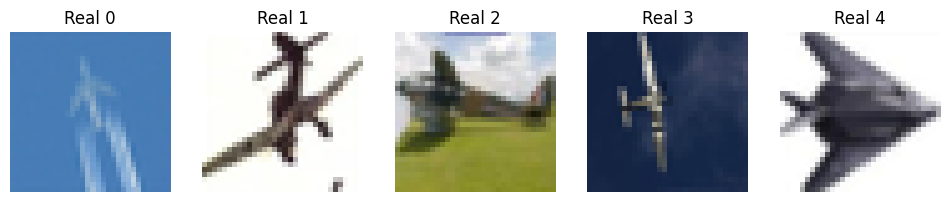

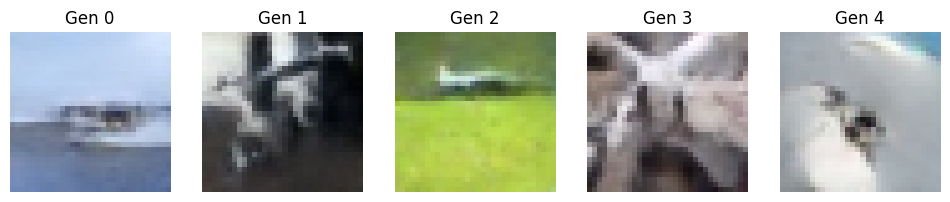

Class 1 (automobile) - Real vs Generated


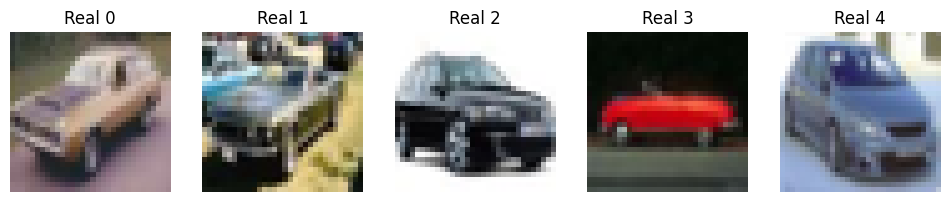

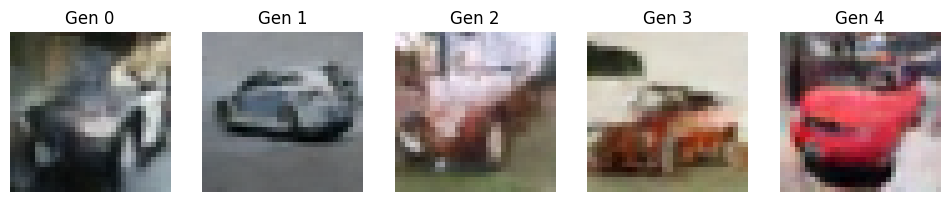

Class 2 (bird) - Real vs Generated


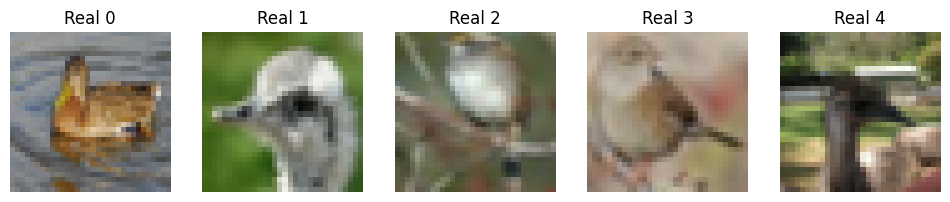

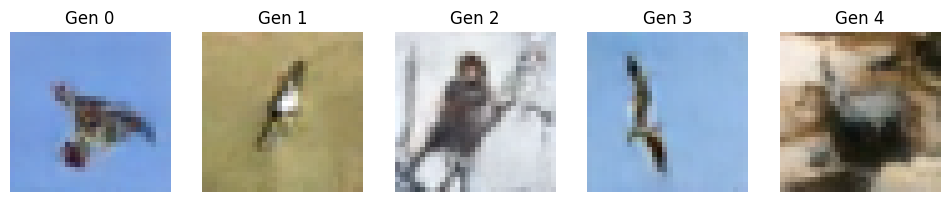

Class 3 (cat) - Real vs Generated


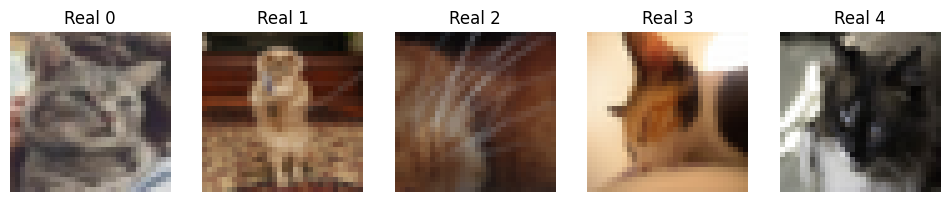

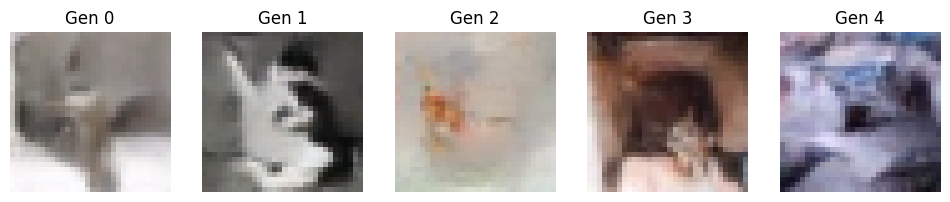

Class 4 (deer) - Real vs Generated


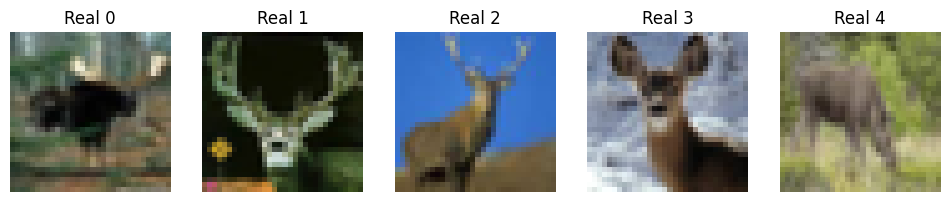

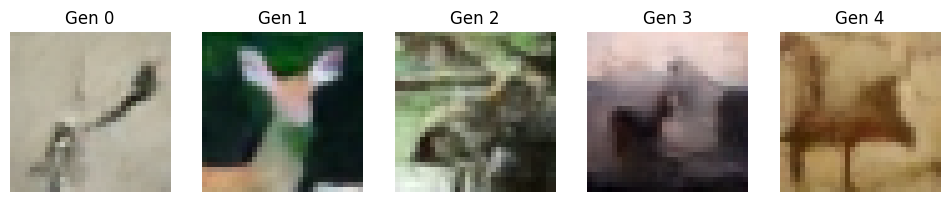

Class 5 (dog) - Real vs Generated


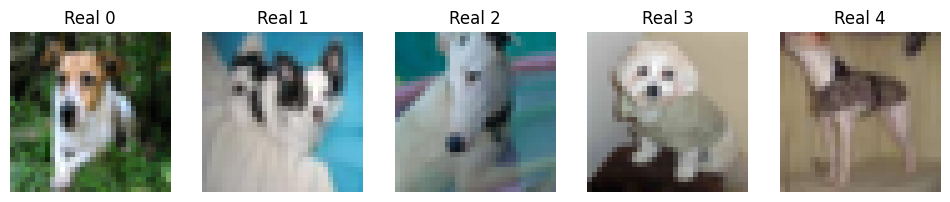

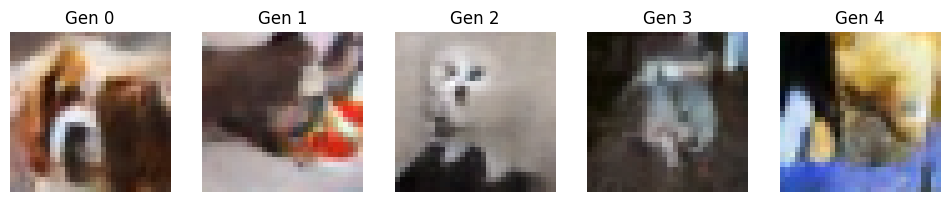

Class 6 (frog) - Real vs Generated


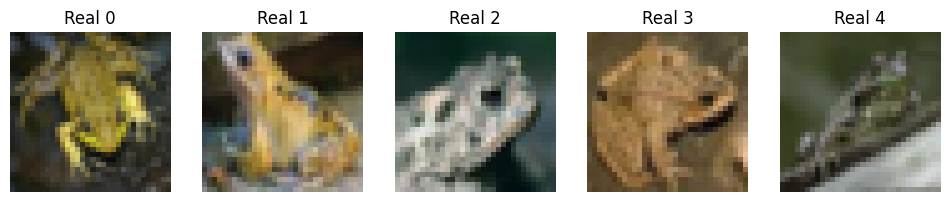

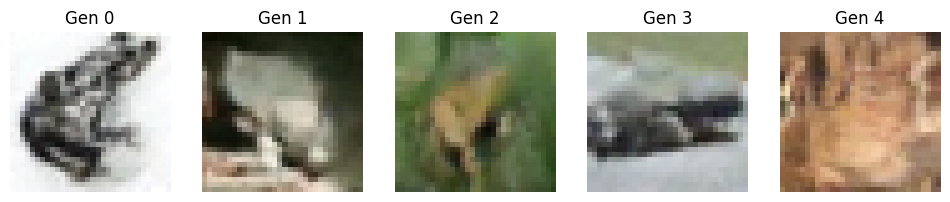

Class 7 (horse) - Real vs Generated


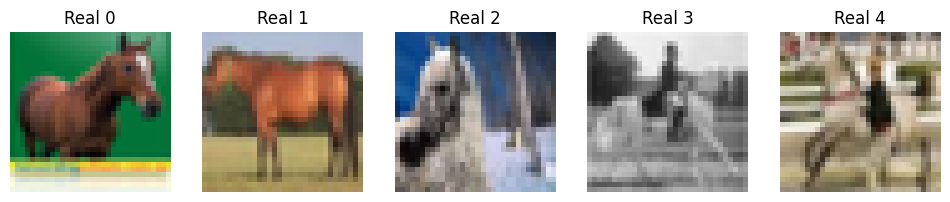

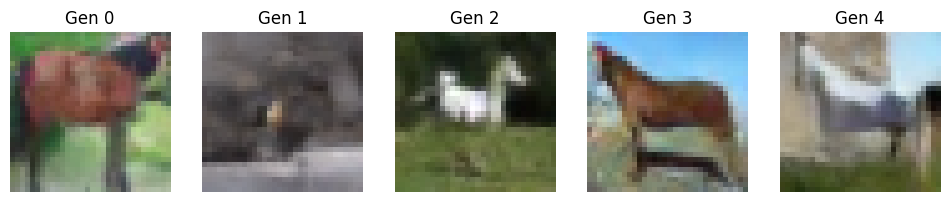

Class 8 (ship) - Real vs Generated


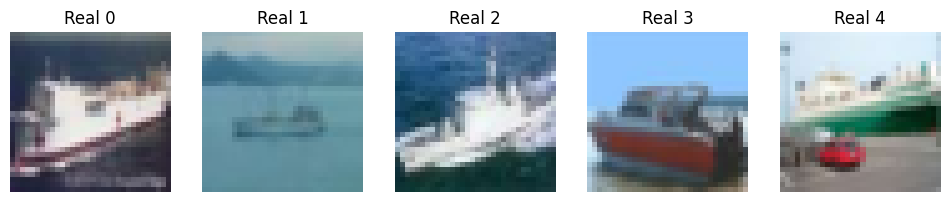

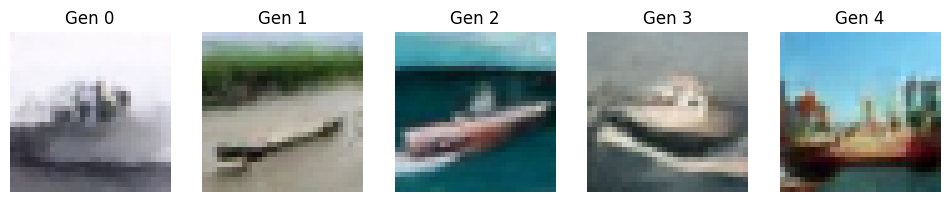

Class 9 (truck) - Real vs Generated


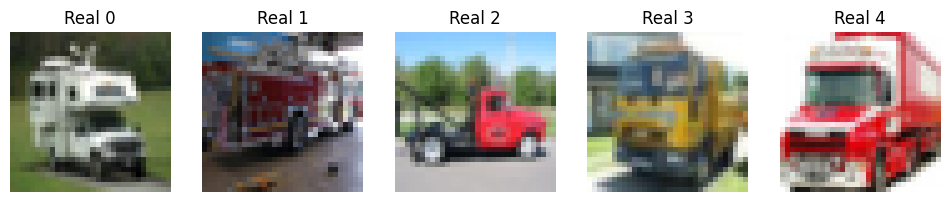

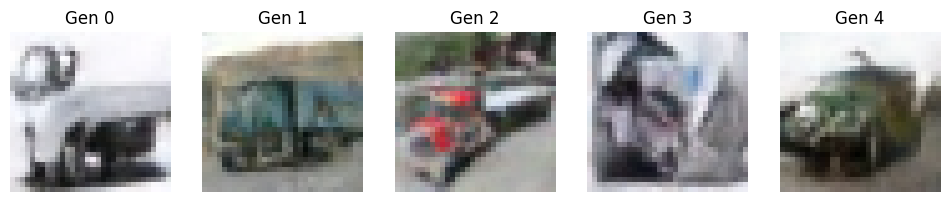

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import copy
import json
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models import resnet18
from tqdm import tqdm
from datasets import load_dataset
from collections import Counter, defaultdict
from PIL import Image  # <--- added

# ============================================================
# 1. 随机种子
# ============================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✅ Random seed set to {seed}")


# ============================================================
# 2. Config
# ============================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed(42)

num_users = 10
dir_alpha = 0.1
epochs_local = 4
rounds_global = 100
batch_size = 256
lr = 0.01
num_workers = 2
num_classes = 10  # CIFAR-10


# ============================================================
# 3. 读取 CIFAR-10 parquet
# ============================================================
train_dataset = load_dataset(
    "parquet",
    data_files="data/cifar10/train.parquet",
    split="train"
)
val_dataset = load_dataset(
    "parquet",
    data_files="data/cifar10/test.parquet",
    split="train"
)


# -----------------------------
# 配置
# -----------------------------
num_classes = 10
samples_per_class = 5  # 每类展示多少张
normalize_mean = (0.5, 0.5, 0.5)
normalize_std = (0.5, 0.5, 0.5)
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(normalize_mean, normalize_std),
])

# CIFAR-10 类别名称
cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# -----------------------------
# 加载生成样本和标签
# -----------------------------
# generated_npy: shape = (passes, N, H, W, 3)
# labels_npy: shape = (passes, N)

generated_npy = np.load("data/generated/generated_cifar10_steps_100/train_generated.npy")
labels_npy = np.load("data/generated/generated_cifar10_steps_100/train_labels.npy")

# -----------------------------
# 从生成样本选取每类样本
# -----------------------------
def sample_gen_by_class(generated_npy, labels_npy, samples_per_class=5):
    gen_by_class = {}
    passes, total = labels_npy.shape
    for c in range(num_classes):
        idx_list = []
        for p in range(passes):
            idx_list += list(np.where(labels_npy[p] == c)[0])
        if len(idx_list) > 0:
            chosen = np.random.choice(idx_list, size=min(samples_per_class, len(idx_list)), replace=False)
            gen_by_class[c] = [(p, i) for p in range(passes) for i in chosen]
    return gen_by_class

gen_by_class = sample_gen_by_class(generated_npy, labels_npy, samples_per_class)

# -----------------------------
# 可视化函数
# -----------------------------
def show_images_grid(images, titles=None, figsize=(12,6)):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
        if titles:
            axes[i].set_title(titles[i])
    plt.show()

# -----------------------------
# 可视化每类的真实样本 vs 生成样本
# -----------------------------
for cls in range(num_classes):
    # 真实样本
    real_indices = [i for i, rec in enumerate(train_dataset) if rec["label"] == cls]
    real_imgs = []
    for i in np.random.choice(real_indices, samples_per_class, replace=False):
        img = train_dataset[i]["img"]
        if isinstance(img, np.ndarray):
            img_pil = Image.fromarray(img)
        else:
            img_pil = img
        real_imgs.append(img_pil)

    # 生成样本
    gen_imgs = []
    chosen_gen = gen_by_class.get(cls, [])[:samples_per_class]
    for p, i in chosen_gen:
        img = generated_npy[p, i]  # NHWC, 0..1
        img_pil = Image.fromarray((img*255).astype(np.uint8))
        gen_imgs.append(img_pil)

    print(f"Class {cls} ({cifar10_classes[cls]}) - Real vs Generated")
    show_images_grid(real_imgs, titles=[f"Real {i}" for i in range(len(real_imgs))])
    show_images_grid(gen_imgs, titles=[f"Gen {i}" for i in range(len(gen_imgs))])


## 2.1 Dataset

We'll start with a classic small dataset, with 32px square images from 10 classes. For convenience we just pull a version that is avalable on the huggingface hub.

In [ ]:
import os
import copy
import json
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models import resnet18
from tqdm import tqdm
from datasets import load_dataset
from collections import Counter, defaultdict
from PIL import Image  # <--- added

# ============================================================
# 1. 随机种子
# ============================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✅ Random seed set to {seed}")


# ============================================================
# 2. Config
# ============================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed(42)

num_users = 10
epochs_local = 1
rounds_global = 50
batch_size = 256
lr = 0.01
num_workers = 2
num_classes = 10  # CIFAR-10


# ============================================================
# 3. 读取 CIFAR-10 parquet
# ============================================================

train_dataset = load_dataset(
    "parquet",
    data_files=f"data/cifar10/train.parquet",
    split="train"
)
val_dataset = load_dataset(
    "parquet",
    data_files=f"data/cifar10/test.parquet",
    split="train"
)


# ============================================================
# 4. 用户 non-IID 划分
# ============================================================
def create_non_iid_splits(dataset, num_users, alpha=0.5):
    labels = np.array([dataset[i]['label'] for i in range(len(dataset))])
    n_classes = int(np.max(labels)) + 1
    user_indices = {i: [] for i in range(num_users)}
    class_indices = [np.where(labels == y)[0] for y in range(n_classes)]

    for idx_list in class_indices:
        np.random.shuffle(idx_list)
        proportions = np.random.dirichlet(np.repeat(alpha, num_users))
        cut = (np.cumsum(proportions) * len(idx_list)).astype(int)

        splits, start = [], 0
        for cp in cut:
            splits.append(idx_list[start:cp])
            start = cp
        if start < len(idx_list):
            splits[-1] = np.concatenate([splits[-1], idx_list[start:]])

        for user, sp in enumerate(splits):
            user_indices[user].extend(sp.tolist())

    return user_indices


user_data_idx = create_non_iid_splits(train_dataset, num_users, dir_alpha)


# ============================================================
# 5. Dataset 封装
# ============================================================
class UserCIFAR100Dataset(Dataset):
    def __init__(self, dataset, indices, transforms=None):
        self.dataset = dataset
        self.indices = indices
        self.transforms = transforms

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        rec = self.dataset[self.indices[idx]]
        img, label = rec["img"], int(rec["label"])
        if self.transforms:
            img = self.transforms(img)
        return img, torch.tensor(label)


# ============================================================
# 6. 模型
# ============================================================
def build_model():
    model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


# ============================================================
# 7. 本地训练
# ============================================================
def local_train_with_accuracy(model, loader, criterion, optimizer, device, epochs=1):
    model.train()
    total_correct, total_samples = 0, 0
    batch_losses = []

    for _ in range(epochs):
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            _, pred = outputs.max(1)
            total_samples += labels.size(0)
            total_correct += pred.eq(labels).sum().item()

    acc = 100.0 * total_correct / total_samples if total_samples > 0 else 0.0
    return copy.deepcopy(model.state_dict()), acc, batch_losses


# ============================================================
# 8. FedAvg
# ============================================================
def fed_avg(models):
    new_dict = copy.deepcopy(models[0])
    for k in new_dict.keys():
        new_dict[k] = torch.stack([m[k].float() for m in models], 0).mean(0)
    return new_dict


# ============================================================
# 9. 测试
# ============================================================
def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            _, pred = model(imgs).max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
    return 100.0 * correct / total if total > 0 else 0.0


# ============================================================
# 10. 加载生成样本 .npy（pretrain / finetune）
# ============================================================
normalize_mean = (0.5, 0.5, 0.5)
normalize_std = (0.5, 0.5, 0.5)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(normalize_mean, normalize_std),
])

steps = 200

# ----- 修改：npy 路径（请按需要改） -----
pretrain_dir = f"/checkpoints_pretrain_imagenet/generated_cifar10_steps_{steps}"   # user-specified
finetune_dir = f"/checkpoints_finetune_cifar10/generated_cifar10_steps_{steps}"   # user-specified

# load pretrain npy (expects train_generated.npy and train_labels.npy)
train_gen_pretrain = np.load(os.path.join(pretrain_dir, "train_generated.npy"))   # shape (passes, N, H, W, 3)
train_labels_pretrain = np.load(os.path.join(pretrain_dir, "train_labels.npy"))   # shape (passes, N)

# load finetune npy
train_gen_finetune = np.load(os.path.join(finetune_dir, "train_generated.npy"))
train_labels_finetune = np.load(os.path.join(finetune_dir, "train_labels.npy"))


# ============================================================
# 11. 构建 index 映射： label -> list of (pass, idx)
# ============================================================
def build_gen_index_npy(labels_npy):
    """
    labels_npy: shape = (passes, total_samples)
    返回： gen_by_label[label] = [ (pass_idx, sample_idx) ]
    """
    passes, total = labels_npy.shape
    gen_by_label = defaultdict(list)
    for p in range(passes):
        for i in range(total):
            label = int(labels_npy[p, i])
            gen_by_label[label].append((p, i))
    return gen_by_label

gen_by_label_pretrain = build_gen_index_npy(train_labels_pretrain)
gen_by_label_finetune = build_gen_index_npy(train_labels_finetune)


# ============================================================
# 12. 根据生成样本补齐每个用户（entries 中 gen 项现在是 (pass, idx) tuple）
# ============================================================
def augment_balanced_user_entries(user_idx, gen_by_label):
    new_entries = {}
    for uid, idxs in user_idx.items():
        entries = [('real', int(i)) for i in idxs]

        labels = [train_dataset[i]["label"] for i in idxs]
        counter = Counter(labels)
        max_count = max(counter.values()) if len(counter) > 0 else 0

        for c in range(num_classes):
            need = max_count - counter.get(c, 0)
            if need > 0 and c in gen_by_label and len(gen_by_label[c]) > 0:
                chosen = random.choices(gen_by_label[c], k=need)
                entries.extend([('gen', name) for name in chosen])

        new_entries[uid] = entries
    return new_entries


user_entries_pre = augment_balanced_user_entries(user_data_idx, gen_by_label_pretrain)
user_entries_fine = augment_balanced_user_entries(user_data_idx, gen_by_label_finetune)


def self_supplement_entries(train_dataset, indices):
    """
    给单个用户做自补（只使用真实样本，不引入生成样本）
    逻辑：将每个类别过采样到用户中出现最多的类别数量
    """
    labels = [train_dataset[i]["label"] for i in indices]
    from collections import Counter
    c = Counter(labels)
    max_cnt = max(c.values()) if len(c) > 0 else 0

    new_indices = []
    for cls, cnt in c.items():
        cls_indices = [i for i in indices if train_dataset[i]["label"] == cls]
        need = max_cnt - cnt
        extra = random.choices(cls_indices, k=need) if need > 0 else []
        new_indices.extend(cls_indices + extra)

    random.shuffle(new_indices)
    return new_indices


# ============================================================
# 13. CombinedUserDatasetFromNpy（支持 real 或 gen）
# ============================================================
class CombinedUserDatasetFromNpy(Dataset):
    def __init__(self, real_dataset, entries, generated_npy, labels_npy, transforms=None):
        """
        entries: list of ("real", real_idx) 或 ("gen", (pass_idx, sample_idx))
        generated_npy: (passes, total, H, W, 3) float in [0,1]
        labels_npy:    (passes, total)
        real_dataset: HF dataset (dict with 'img','label') OR a Dataset that returns (img_tensor,label)
        """
        self.real_dataset = real_dataset
        self.entries = entries
        self.generated_npy = generated_npy
        self.labels_npy = labels_npy
        self.transforms = transforms

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry_type, entry_val = self.entries[idx]

        if entry_type == "real":
            # handle HF dataset (dict) or already wrapped Dataset that returns (img,label)
            rec = self.real_dataset[entry_val]
            if isinstance(rec, dict):
                img = rec.get("img")
                label = int(rec.get("label", -1))
                if self.transforms:
                    img = self.transforms(img)
                return img, torch.tensor(label, dtype=torch.long)
            else:
                # assume (img_tensor, label)
                return rec  # already (img_tensor, label_tensor)

        elif entry_type == "gen":
            p, i = entry_val
            img = self.generated_npy[p, i]      # NHWC, [0..1]
            label = int(self.labels_npy[p, i])

            # convert NHWC numpy -> PIL -> apply transforms (same pipeline as train_transform)
            img_pil = Image.fromarray((img * 255).astype(np.uint8))
            if self.transforms:
                img_t = self.transforms(img_pil)
            else:
                # default: convert to tensor
                img_t = transforms.ToTensor()(img_pil)
            return img_t, torch.tensor(label, dtype=torch.long)
        else:
            raise ValueError("Unknown entry type")



# ============================================================
# 封装联邦训练为函数：支持是否使用生成样本
# ============================================================
def run_experiment(mode="baseline", tag="exp", dir_alpha=0.1):
    """
    mode: 'baseline' | 'with_gen' | 'self_supplement' | 'with_gen_pretrain'
    """
    os.makedirs("fed_checkpoints_cifar10", exist_ok=True)
    global_model = build_model().to(device)
    criterion = nn.CrossEntropyLoss()
    best_avg_acc = -1.0
    best_model_state = None
    best_round_idx = -1
    train_logs = []
    # 创建用户数据划分（每次实验重新创建，因为dir_alpha不同）
    user_data_idx = create_non_iid_splits(train_dataset, num_users, dir_alpha)
    
    # 构建用户条目（只在需要时）
    if mode == "with_gen_pretrain":
        user_entries_pre = augment_balanced_user_entries(user_data_idx, gen_by_label_pretrain)
    elif mode == "with_gen":
        user_entries_fine = augment_balanced_user_entries(user_data_idx, gen_by_label_finetune)
    # 全局评估 loader
    full_train_loader = DataLoader(
        UserCIFAR100Dataset(train_dataset, range(len(train_dataset)), transforms=train_transform),
        batch_size=1024, shuffle=False, num_workers=num_workers
    )
    full_val_loader = DataLoader(
        UserCIFAR100Dataset(val_dataset, range(len(val_dataset)), transforms=train_transform),
        batch_size=1024, shuffle=False, num_workers=num_workers
    )
    for round_idx in tqdm(range(1, rounds_global + 1), desc=f"🌍 Global Rounds ({mode}, α={dir_alpha})", ncols=100):
        user_models, user_train_accuracies, round_losses = [], [], []
        for user in range(num_users):
            # === baseline: 只用真实数据 ===
            if mode == "baseline":
                indices = user_data_idx[user]
                user_dataset = UserCIFAR100Dataset(train_dataset, indices, transforms=train_transform)
            # === real-only 的补充策略 ===
            elif mode == "self_supplement":
                indices = self_supplement_entries(train_dataset, user_data_idx[user])
                user_dataset = UserCIFAR100Dataset(train_dataset, indices, transforms=train_transform)
            # === synthetic（finetune 版本）===
            elif mode == "with_gen":
                entries = user_entries_fine[user]
                # use npy dataset wrapper
                user_dataset = CombinedUserDatasetFromNpy(
                    real_dataset=train_dataset,
                    entries=entries,
                    generated_npy=train_gen_finetune,
                    labels_npy=train_labels_finetune,
                    transforms=train_transform
                )
            # === synthetic（pretrain 版本）===
            elif mode == "with_gen_pretrain":
                entries = user_entries_pre[user]
                user_dataset = CombinedUserDatasetFromNpy(
                    real_dataset=train_dataset,
                    entries=entries,
                    generated_npy=train_gen_pretrain,
                    labels_npy=train_labels_pretrain,
                    transforms=train_transform
                )
            else:
                raise ValueError(f"Unknown mode: {mode}")
            user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=True,
                                     num_workers=num_workers, drop_last=True)
            local_model = copy.deepcopy(global_model)
            optimizer = optim.SGD(local_model.parameters(), lr=lr)
            user_state, train_acc, batch_losses = local_train_with_accuracy(
                local_model, user_loader, criterion, optimizer, device, epochs_local
            )
            user_models.append(user_state)
            user_train_accuracies.append(train_acc)
            round_losses.extend(batch_losses)
        # 聚合
        global_dict = fed_avg(user_models)
        global_model.load_state_dict(global_dict)
        # 评估
        def evaluate(model, loader):
            model.eval()
            total_loss, total_correct, total_samples = 0.0, 0, 0
            with torch.no_grad():
                for imgs, labels in loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item() * labels.size(0)
                    _, preds = outputs.max(1)
                    total_correct += preds.eq(labels).sum().item()
                    total_samples += labels.size(0)
            avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
            avg_acc = 100.0 * total_correct / total_samples if total_samples > 0 else 0.0
            return avg_loss, avg_acc
        train_loss_full, train_acc_full = evaluate(global_model, full_train_loader)
        val_loss_full, val_acc_full = evaluate(global_model, full_val_loader)
        train_logs.append({
            "round": round_idx,
            "train_loss": train_loss_full,
            "train_acc": train_acc_full,
            "val_loss": val_loss_full,
            "val_acc": val_acc_full,
        })
        if val_acc_full > best_avg_acc:
            best_avg_acc = val_acc_full
            best_model_state = copy.deepcopy(global_model.state_dict())
            best_round_idx = round_idx
    # save logs
    log_path = f"fed_checkpoints_cifar10/train_logs_{tag}_{mode}_{dir_alpha}_{steps}.json"
    with open(log_path, "w") as f:
        json.dump(train_logs, f, indent=2)
    print(f"💾 Training logs saved to {log_path}")

    save_path = f"fed_checkpoints_cifar10/fed_best_{tag}_{mode}_{dir_alpha}_{steps}.pt"
    torch.save(best_model_state, save_path)

    print(f"✅ [{mode}] best val_acc={best_avg_acc:.2f}% @ round {best_round_idx}")
    return best_avg_acc, best_round_idx
# === 遍历不同的 dir_alpha 值 ===
dir_alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for dir_alpha in dir_alpha_values:
    print(f"\n{'='*60}")
    print(f"🚀 开始实验: dir_alpha = {dir_alpha}")
    print(f"{'='*60}")
    
    print("\n🚀 Experiment 1: Baseline (no supplement)")
    acc_base, round_base = run_experiment(mode="baseline", tag="expA", dir_alpha=dir_alpha)

    print("\n🚀 Experiment 4: Pretrain Generated Supplement")
    acc_gen_pretrain, round_gen_pretrain = run_experiment(mode="with_gen_pretrain", tag="expD", dir_alpha=dir_alpha)


✅ Random seed set to 42

🚀 开始实验: dir_alpha = 0.1

🚀 Experiment 1: Baseline (no supplement)


🌍 Global Rounds (baseline, α=0.1): 100%|███████████████████████████| 50/50 [15:12<00:00, 18.25s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expA_baseline_0.1_200.json
✅ [baseline] best val_acc=46.76% @ round 36

🚀 Experiment 4: Pretrain Generated Supplement


🌍 Global Rounds (with_gen_pretrain, α=0.1): 100%|██████████████████| 50/50 [29:25<00:00, 35.30s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expD_with_gen_pretrain_0.1_200.json
✅ [with_gen_pretrain] best val_acc=53.98% @ round 17

🚀 开始实验: dir_alpha = 0.2

🚀 Experiment 1: Baseline (no supplement)


🌍 Global Rounds (baseline, α=0.2): 100%|███████████████████████████| 50/50 [15:24<00:00, 18.49s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expA_baseline_0.2_200.json
✅ [baseline] best val_acc=48.31% @ round 46

🚀 Experiment 4: Pretrain Generated Supplement


🌍 Global Rounds (with_gen_pretrain, α=0.2): 100%|██████████████████| 50/50 [25:14<00:00, 30.29s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expD_with_gen_pretrain_0.2_200.json
✅ [with_gen_pretrain] best val_acc=54.29% @ round 27

🚀 开始实验: dir_alpha = 0.3

🚀 Experiment 1: Baseline (no supplement)


🌍 Global Rounds (baseline, α=0.3): 100%|███████████████████████████| 50/50 [15:14<00:00, 18.29s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expA_baseline_0.3_200.json
✅ [baseline] best val_acc=51.98% @ round 48

🚀 Experiment 4: Pretrain Generated Supplement


🌍 Global Rounds (with_gen_pretrain, α=0.3): 100%|██████████████████| 50/50 [24:14<00:00, 29.09s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expD_with_gen_pretrain_0.3_200.json
✅ [with_gen_pretrain] best val_acc=54.39% @ round 26

🚀 开始实验: dir_alpha = 0.4

🚀 Experiment 1: Baseline (no supplement)


🌍 Global Rounds (baseline, α=0.4): 100%|███████████████████████████| 50/50 [15:18<00:00, 18.37s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expA_baseline_0.4_200.json
✅ [baseline] best val_acc=51.47% @ round 49

🚀 Experiment 4: Pretrain Generated Supplement


🌍 Global Rounds (with_gen_pretrain, α=0.4): 100%|██████████████████| 50/50 [24:23<00:00, 29.27s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expD_with_gen_pretrain_0.4_200.json
✅ [with_gen_pretrain] best val_acc=55.27% @ round 29

🚀 开始实验: dir_alpha = 0.5

🚀 Experiment 1: Baseline (no supplement)


🌍 Global Rounds (baseline, α=0.5): 100%|███████████████████████████| 50/50 [15:20<00:00, 18.41s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expA_baseline_0.5_200.json
✅ [baseline] best val_acc=51.77% @ round 49

🚀 Experiment 4: Pretrain Generated Supplement


🌍 Global Rounds (with_gen_pretrain, α=0.5): 100%|██████████████████| 50/50 [22:02<00:00, 26.45s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expD_with_gen_pretrain_0.5_200.json
✅ [with_gen_pretrain] best val_acc=54.80% @ round 23

🚀 开始实验: dir_alpha = 0.6

🚀 Experiment 1: Baseline (no supplement)


🌍 Global Rounds (baseline, α=0.6): 100%|███████████████████████████| 50/50 [15:15<00:00, 18.31s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expA_baseline_0.6_200.json
✅ [baseline] best val_acc=53.54% @ round 49

🚀 Experiment 4: Pretrain Generated Supplement


🌍 Global Rounds (with_gen_pretrain, α=0.6): 100%|██████████████████| 50/50 [22:30<00:00, 27.00s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expD_with_gen_pretrain_0.6_200.json
✅ [with_gen_pretrain] best val_acc=54.52% @ round 26

🚀 开始实验: dir_alpha = 0.7

🚀 Experiment 1: Baseline (no supplement)


🌍 Global Rounds (baseline, α=0.7): 100%|███████████████████████████| 50/50 [15:20<00:00, 18.40s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expA_baseline_0.7_200.json
✅ [baseline] best val_acc=53.34% @ round 44

🚀 Experiment 4: Pretrain Generated Supplement


🌍 Global Rounds (with_gen_pretrain, α=0.7): 100%|██████████████████| 50/50 [21:12<00:00, 25.46s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expD_with_gen_pretrain_0.7_200.json
✅ [with_gen_pretrain] best val_acc=54.83% @ round 30

🚀 开始实验: dir_alpha = 0.8

🚀 Experiment 1: Baseline (no supplement)


🌍 Global Rounds (baseline, α=0.8): 100%|███████████████████████████| 50/50 [15:19<00:00, 18.39s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expA_baseline_0.8_200.json
✅ [baseline] best val_acc=54.88% @ round 48

🚀 Experiment 4: Pretrain Generated Supplement


🌍 Global Rounds (with_gen_pretrain, α=0.8): 100%|██████████████████| 50/50 [20:54<00:00, 25.09s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expD_with_gen_pretrain_0.8_200.json
✅ [with_gen_pretrain] best val_acc=54.31% @ round 47

🚀 开始实验: dir_alpha = 0.9

🚀 Experiment 1: Baseline (no supplement)


🌍 Global Rounds (baseline, α=0.9): 100%|███████████████████████████| 50/50 [15:33<00:00, 18.67s/it]


💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expA_baseline_0.9_200.json
✅ [baseline] best val_acc=54.67% @ round 48

🚀 Experiment 4: Pretrain Generated Supplement


🌍 Global Rounds (with_gen_pretrain, α=0.9): 100%|██████████████████| 50/50 [20:55<00:00, 25.10s/it]

💾 Training logs saved to fed_checkpoints_cifar10/train_logs_expD_with_gen_pretrain_0.9_200.json
✅ [with_gen_pretrain] best val_acc=55.99% @ round 28


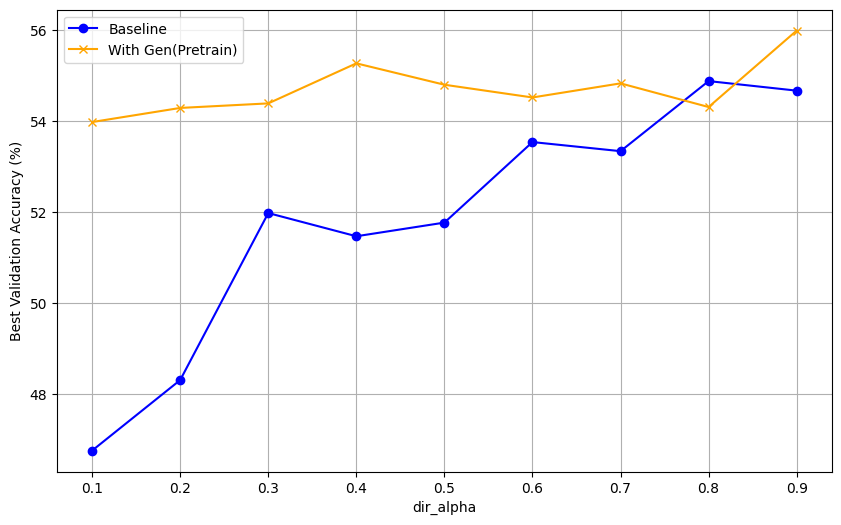

dir_alpha = 0.1: Baseline = 46.76%, Pretrain Generated Supplement = 53.98%
dir_alpha = 0.2: Baseline = 48.31%, Pretrain Generated Supplement = 54.29%
dir_alpha = 0.3: Baseline = 51.98%, Pretrain Generated Supplement = 54.39%
dir_alpha = 0.4: Baseline = 51.47%, Pretrain Generated Supplement = 55.27%
dir_alpha = 0.5: Baseline = 51.77%, Pretrain Generated Supplement = 54.80%
dir_alpha = 0.6: Baseline = 53.54%, Pretrain Generated Supplement = 54.52%
dir_alpha = 0.7: Baseline = 53.34%, Pretrain Generated Supplement = 54.83%
dir_alpha = 0.8: Baseline = 54.88%, Pretrain Generated Supplement = 54.31%
dir_alpha = 0.9: Baseline = 54.67%, Pretrain Generated Supplement = 55.99%


In [1]:
import json
import matplotlib.pyplot as plt

# 定义函数读取日志并提取最优准确率
def read_best_acc_from_log(log_file):
    with open(log_file, 'r') as f:
        data = json.load(f)
    # 提取每轮训练的最佳准确率
    best_acc = [entry['val_acc'] for entry in data]
    return max(best_acc)  # 取出最高的验证准确率

# 设置 dir_alpha 值范围和对应的文件路径
dir_alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
log_dir = "fed_checkpoints_cifar10/"  # 训练日志存储的文件夹路径

# 存储每个 dir_alpha 对应的最佳准确率
best_acc_values_baseline = []
best_acc_values_gen_pretrain = []

for dir_alpha in dir_alpha_values:
    # 构造对应的日志文件路径
    baseline_log_path = f"{log_dir}train_logs_expA_baseline_{dir_alpha}_200.json"
    gen_pretrain_log_path = f"{log_dir}train_logs_expD_with_gen_pretrain_{dir_alpha}_200.json"
    
    # 读取每个 log 文件的最佳准确率
    best_acc_baseline = read_best_acc_from_log(baseline_log_path)
    best_acc_gen_pretrain = read_best_acc_from_log(gen_pretrain_log_path)
    
    # 存储结果
    best_acc_values_baseline.append(best_acc_baseline)
    best_acc_values_gen_pretrain.append(best_acc_gen_pretrain)

# 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(dir_alpha_values, best_acc_values_baseline, marker='o', label='Baseline', color='blue')
plt.plot(dir_alpha_values, best_acc_values_gen_pretrain, marker='x', label='With Gen(Pretrain)', color='orange')

plt.xlabel('dir_alpha')
plt.ylabel('Best Validation Accuracy (%)')
plt.xticks(dir_alpha_values)  # 显示所有 dir_alpha 值
plt.legend()
plt.grid(True)
plt.show()

# 打印每个 dir_alpha 对应的最佳准确率
for i, dir_alpha in enumerate(dir_alpha_values):
    print(f"dir_alpha = {dir_alpha}: Baseline = {best_acc_values_baseline[i]:.2f}%, "
          f"Pretrain Generated Supplement = {best_acc_values_gen_pretrain[i]:.2f}%")


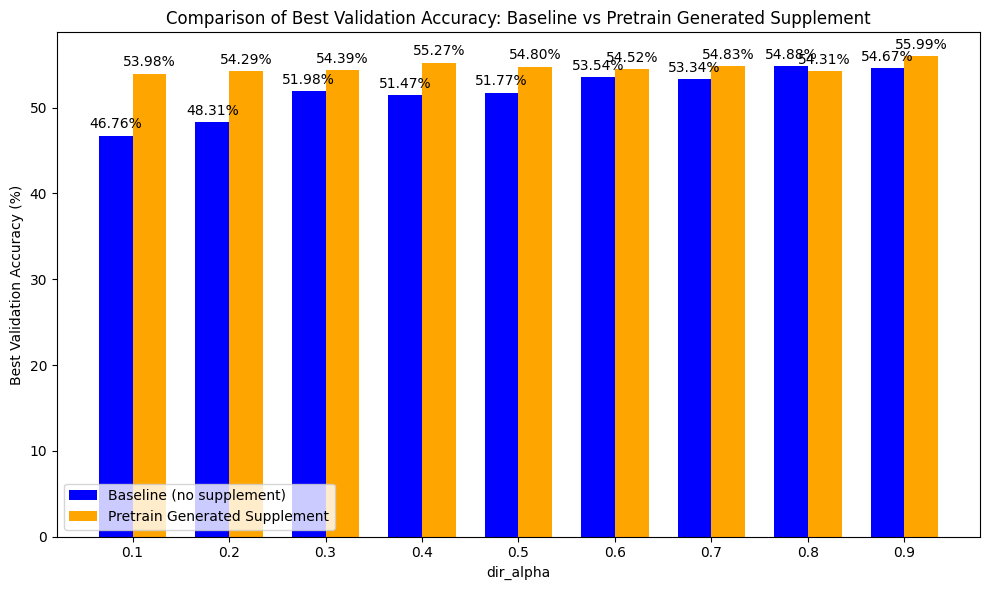

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 设置 dir_alpha 值范围
dir_alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
log_dir = "fed_checkpoints_cifar10/"  # 训练日志存储的文件夹路径

# 存储每个 dir_alpha 对应的最佳准确率
best_acc_values_baseline = []
best_acc_values_gen_pretrain = []

for dir_alpha in dir_alpha_values:
    # 构造对应的日志文件路径
    baseline_log_path = f"{log_dir}train_logs_expA_baseline_{dir_alpha}_200.json"
    gen_pretrain_log_path = f"{log_dir}train_logs_expD_with_gen_pretrain_{dir_alpha}_200.json"
    
    # 读取每个 log 文件的最佳准确率
    best_acc_baseline = read_best_acc_from_log(baseline_log_path)
    best_acc_gen_pretrain = read_best_acc_from_log(gen_pretrain_log_path)
    
    # 存储结果
    best_acc_values_baseline.append(best_acc_baseline)
    best_acc_values_gen_pretrain.append(best_acc_gen_pretrain)

# 绘制柱状图
width = 0.35  # 每组柱子的宽度
x = np.arange(len(dir_alpha_values))  # x轴的位置

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, best_acc_values_baseline, width, label='Baseline (no supplement)', color='blue')
rects2 = ax.bar(x + width/2, best_acc_values_gen_pretrain, width, label='Pretrain Generated Supplement', color='orange')

# 添加标签、标题等
ax.set_xlabel('dir_alpha')
ax.set_ylabel('Best Validation Accuracy (%)')
ax.set_title('Comparison of Best Validation Accuracy: Baseline vs Pretrain Generated Supplement')
ax.set_xticks(x)
ax.set_xticklabels(dir_alpha_values)
ax.legend()

# 自动标注柱子上的数值
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 标注的偏移量
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()


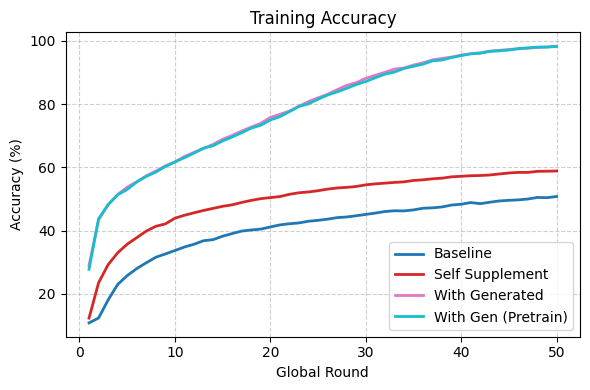

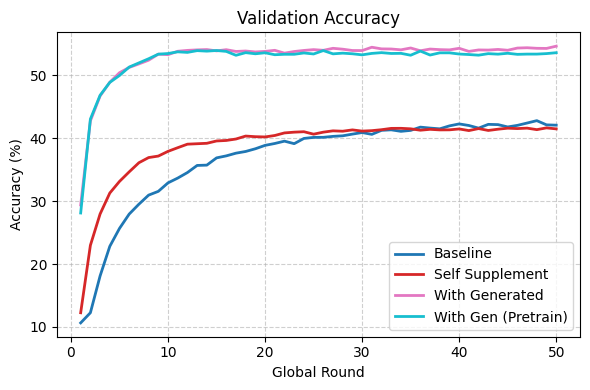

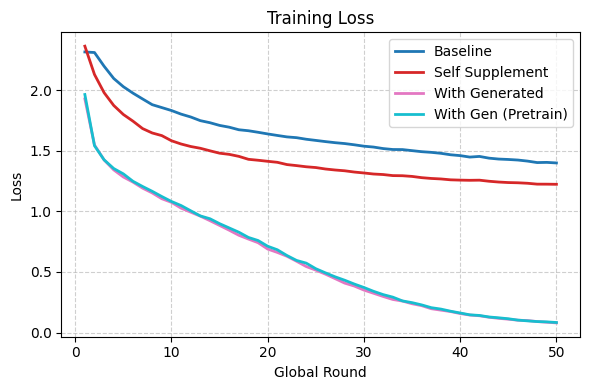

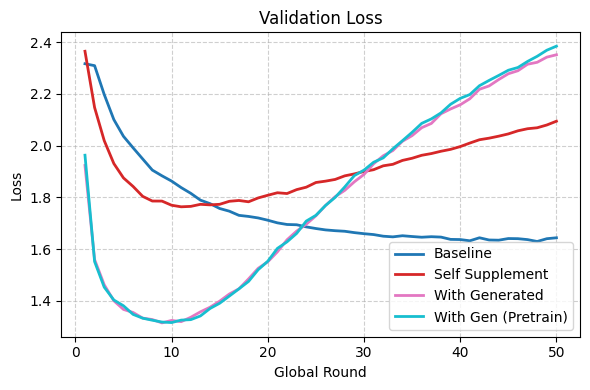

In [10]:
import json
import matplotlib.pyplot as plt
import os
import numpy as np

# =========================
# 参数配置
# =========================
dir_alpha = 0.1  # 与训练脚本一致
log_dir = "fed_checkpoints_cifar10"
files = {
    "Baseline": f"train_logs_expA_baseline_{dir_alpha}_{steps}.json",
    "Self Supplement": f"train_logs_expB_self_supplement_{dir_alpha}_{steps}.json",
    "With Generated": f"train_logs_expC_with_gen_{dir_alpha}_{steps}.json",
    "With Gen (Pretrain)": f"train_logs_expD_with_gen_pretrain_{dir_alpha}_{steps}.json",
}

# 颜色方案（tab10）
colors = plt.cm.tab10(np.linspace(0, 1, len(files)))

# =========================
# 读取日志函数
# =========================
def load_log(filepath):
    with open(filepath, "r") as f:
        data = json.load(f)
    rounds = [d["round"] for d in data]
    train_acc = [d["train_acc"] for d in data]
    val_acc = [d["val_acc"] for d in data]
    train_loss = [d["train_loss"] for d in data]
    val_loss = [d["val_loss"] for d in data]
    return rounds, train_acc, val_acc, train_loss, val_loss

# =========================
# 绘制单个指标
# =========================
def plot_metric(metric_name, ylabel, key_idx):
    plt.figure(figsize=(6, 4))
    for i, (label, filename) in enumerate(files.items()):
        path = os.path.join(log_dir, filename)
        if not os.path.exists(path):
            print(f"⚠️ 文件 {filename} 不存在，跳过。")
            continue
        rounds, train_acc, val_acc, train_loss, val_loss = load_log(path)
        metric_data = [train_acc, val_acc, train_loss, val_loss][key_idx]
        plt.plot(
            rounds,
            metric_data,
            label=label,
            color=colors[i],       # ✅ 使用 tab10 调色
            linewidth=2,
        )

    plt.xlabel("Global Round")
    plt.ylabel(ylabel)
    plt.title(metric_name)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# =========================
# 绘制全部指标
# =========================
plot_metric("Training Accuracy", "Accuracy (%)", 0)
plot_metric("Validation Accuracy", "Accuracy (%)", 1)
plot_metric("Training Loss", "Loss", 2)
plot_metric("Validation Loss", "Loss", 3)


Device: cuda

========== Evaluating dir_alpha = 0.1 ==========


Eval α=0.1, ratio=0.00: 100%|██████████| 40/40 [00:01<00:00, 20.72it/s]


  ratio=0.00  → avg per-class acc=47.59%


Eval α=0.1, ratio=0.10: 100%|██████████| 40/40 [00:01<00:00, 20.48it/s]


  ratio=0.10  → avg per-class acc=51.56%


Eval α=0.1, ratio=0.20: 100%|██████████| 40/40 [00:01<00:00, 20.48it/s]


  ratio=0.20  → avg per-class acc=53.13%


Eval α=0.1, ratio=0.30: 100%|██████████| 40/40 [00:01<00:00, 20.61it/s]


  ratio=0.30  → avg per-class acc=54.27%


Eval α=0.1, ratio=0.40: 100%|██████████| 40/40 [00:01<00:00, 20.66it/s]


  ratio=0.40  → avg per-class acc=55.32%


Eval α=0.1, ratio=0.50: 100%|██████████| 40/40 [00:01<00:00, 20.54it/s]


  ratio=0.50  → avg per-class acc=56.44%


Eval α=0.1, ratio=0.60: 100%|██████████| 40/40 [00:01<00:00, 20.69it/s]


  ratio=0.60  → avg per-class acc=55.86%


Eval α=0.1, ratio=0.70: 100%|██████████| 40/40 [00:01<00:00, 20.32it/s]


  ratio=0.70  → avg per-class acc=56.62%


Eval α=0.1, ratio=0.80: 100%|██████████| 40/40 [00:01<00:00, 20.27it/s]


  ratio=0.80  → avg per-class acc=56.91%


Eval α=0.1, ratio=0.90: 100%|██████████| 40/40 [00:01<00:00, 20.36it/s]


  ratio=0.90  → avg per-class acc=57.70%


Eval α=0.1, ratio=1.00: 100%|██████████| 40/40 [00:01<00:00, 20.57it/s]


  ratio=1.00  → avg per-class acc=57.85%

========== Evaluating dir_alpha = 0.5 ==========


Eval α=0.5, ratio=0.00: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


  ratio=0.00  → avg per-class acc=57.86%


Eval α=0.5, ratio=0.10: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


  ratio=0.10  → avg per-class acc=61.58%


Eval α=0.5, ratio=0.20: 100%|██████████| 40/40 [00:01<00:00, 20.71it/s]


  ratio=0.20  → avg per-class acc=63.65%


Eval α=0.5, ratio=0.30: 100%|██████████| 40/40 [00:01<00:00, 20.69it/s]


  ratio=0.30  → avg per-class acc=63.28%


Eval α=0.5, ratio=0.40: 100%|██████████| 40/40 [00:01<00:00, 20.56it/s]


  ratio=0.40  → avg per-class acc=64.70%


Eval α=0.5, ratio=0.50: 100%|██████████| 40/40 [00:01<00:00, 20.15it/s]


  ratio=0.50  → avg per-class acc=65.17%


Eval α=0.5, ratio=0.60: 100%|██████████| 40/40 [00:01<00:00, 20.48it/s]


  ratio=0.60  → avg per-class acc=65.53%


Eval α=0.5, ratio=0.70: 100%|██████████| 40/40 [00:01<00:00, 20.77it/s]


  ratio=0.70  → avg per-class acc=66.64%


Eval α=0.5, ratio=0.80: 100%|██████████| 40/40 [00:01<00:00, 20.35it/s]


  ratio=0.80  → avg per-class acc=66.21%


Eval α=0.5, ratio=0.90: 100%|██████████| 40/40 [00:01<00:00, 20.46it/s]


  ratio=0.90  → avg per-class acc=66.84%


Eval α=0.5, ratio=1.00: 100%|██████████| 40/40 [00:01<00:00, 20.33it/s]


  ratio=1.00  → avg per-class acc=66.63%


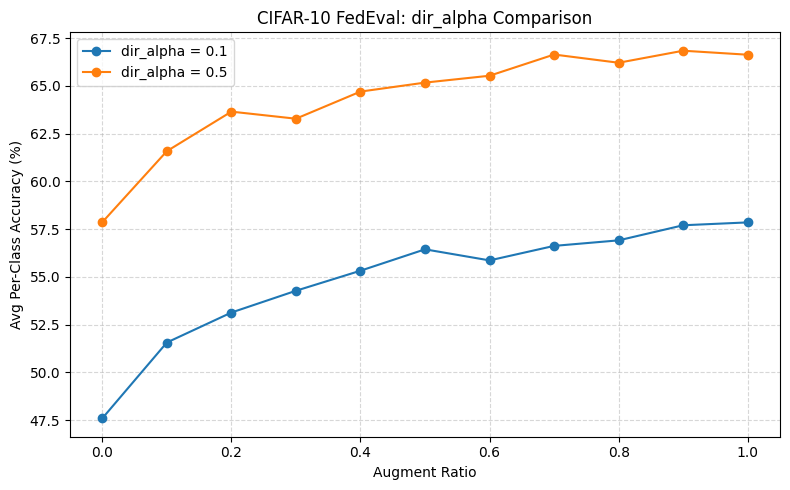

In [9]:
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path
from torchvision.models import resnet18
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------- 环境与配置 ----------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

assert 'cifar10' in globals(), "Please load cifar10 dataset first (e.g. cifar10 = load_dataset('cifar10'))"

# 与训练保持一致的归一化
normalize_mean = (0.5, 0.5, 0.5)
normalize_std = (0.5, 0.5, 0.5)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(normalize_mean, normalize_std),
])

# 测试集包装
class EvalCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        item = self.dataset[idx]
        img = item['image']
        lbl = int(item['label'])
        if self.transforms:
            img = self.transforms(img)
        return img, torch.tensor(lbl, dtype=torch.long)

test_dataset = EvalCIFAR10Dataset(cifar10['test'], transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# 模型定义
def build_model(num_classes=10):
    model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# 要比较的 dir_alpha 值
dir_alpha_list = [0.1, 0.5]
augment_ratios = [round(float(x),2) for x in np.arange(0.0, 1.1, 0.1)]

# 记录结果
results = {}

for dir_alpha in dir_alpha_list:
    base_ckpt_dir = Path(f"fed_checkpoints/cifar10/dir_alpha_{dir_alpha}")
    ratio_list, avg_per_class_accs = [], []

    print(f"\n========== Evaluating dir_alpha = {dir_alpha} ==========")
    for ratio in augment_ratios:
        ckpt_path = base_ckpt_dir / f"final_best_model_ratio{ratio}_dir_alpha_{dir_alpha}.pt"
        if not ckpt_path.exists():
            print(f"⚠️ Missing checkpoint for ratio={ratio:.2f}")
            continue

        model = build_model(num_classes=10).to(device)
        ckpt = torch.load(str(ckpt_path), map_location=device)
        try:
            model.load_state_dict(ckpt)
        except Exception:
            if isinstance(ckpt, dict) and 'state_dict' in ckpt:
                model.load_state_dict(ckpt['state_dict'])
            else:
                model.load_state_dict(ckpt, strict=False)
        model.eval()

        cm = torch.zeros((10, 10), dtype=torch.long)
        total_correct, total_samples = 0, 0

        with torch.no_grad():
            for imgs, labels in tqdm(test_loader, desc=f"Eval α={dir_alpha}, ratio={ratio:.2f}"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = outputs.max(1)
                total_correct += preds.eq(labels).sum().item()
                total_samples += labels.size(0)
                for t, p in zip(labels.view(-1), preds.view(-1)):
                    cm[t.long(), p.long()] += 1

        # 每类准确率
        per_class_acc = []
        for c in range(10):
            true_c = cm[c, :].sum().item()
            correct_c = cm[c, c].item()
            acc_c = 100.0 * correct_c / true_c if true_c > 0 else 0.0
            per_class_acc.append(acc_c)

        avg_acc = np.mean(per_class_acc)
        ratio_list.append(ratio)
        avg_per_class_accs.append(avg_acc)
        print(f"  ratio={ratio:.2f}  → avg per-class acc={avg_acc:.2f}%")

    results[dir_alpha] = (ratio_list, avg_per_class_accs)

# ---------- 可视化 ----------
plt.figure(figsize=(8, 5))
for dir_alpha, (ratios, accs) in results.items():
    plt.plot(ratios, accs, marker='o', label=f"dir_alpha = {dir_alpha}")

plt.xlabel("Augment Ratio")
plt.ylabel("Avg Per-Class Accuracy (%)")
plt.title("CIFAR-10 FedEval: dir_alpha Comparison")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 🔍 Evaluate local accuracy of each user after federated training
# ============================================================

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt

# ⚙️ Settings (same as during training)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
num_workers = 2
normalize_mean = (0.5, 0.5, 0.5)
normalize_std = (0.5, 0.5, 0.5)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(normalize_mean, normalize_std),
])


# ===============================
# User-level evaluation function
# ===============================
def evaluate_local_accuracy(model, dataset, transform, batch_size=128, num_workers=2):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return 100.0 * correct / total


# ============================================================
# 📈 Evaluate all models (different augment_ratio) and plot
# ============================================================
dir_alpha = 0.1
checkpoint_dir = "/fed_checkpoints"

ratios = np.arange(0.0, 1.0 + 0.1, 0.1)
avg_acc_results = []

for augment_ratio in ratios:
    model_path = os.path.join(checkpoint_dir, f"final_model_ratio{augment_ratio:.1f}_dir_alpha_{dir_alpha}.pt")
    if not os.path.exists(model_path):
        print(f"⚠️ Model not found: {model_path}")
        avg_acc_results.append(np.nan)
        continue

    print(f"\n🧩 Loading model from: {model_path}")
    model = build_model(num_classes=10).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # =============== Evaluate per user ===============
    user_accs = []
    for user in range(num_users):
        user_dataset = UserCIFAR10Dataset(
            cifar10['train'],
            user_data_idx[user],
            transforms=train_transform
        )
        acc = evaluate_local_accuracy(model, user_dataset, train_transform)
        user_accs.append(acc)
    
    avg_acc = np.mean(user_accs)
    avg_acc_results.append(avg_acc)
    print(f"✅ Augment Ratio = {augment_ratio:.1f} → Average Accuracy: {avg_acc:.2f}%")

# =============== Plot results ===============
plt.figure(figsize=(8, 5))
plt.plot(ratios, avg_acc_results, marker='o', linewidth=2)
plt.title(f"Average User Train Accuracy vs Augment Ratio (Dirichlet α={dir_alpha})")
plt.xlabel("Augment Ratio")
plt.ylabel("Average Train Accuracy (%)")
plt.grid(True)
plt.xticks(ratios)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# =============== Print summary ===============
print("\n======= Summary =======")
for r, acc in zip(ratios, avg_acc_results):
    print(f"Augment Ratio = {r:.1f} → Average Accuracy = {acc:.2f}%")
